# Goal  
The objective of this project is to maximize profits in the online MMORPG Old School RuneScape by leveraging the in-game Grand Exchange, which functions similarly to a real-world stock market but deals in in-game items instead of financial instruments. Our goal is to capitalize on price fluctuations within the Grand Exchange to generate profit. To achieve this, we plan to develop a model capable of predicting item prices at least one week into the future. If the model predicts a drop in prices, we will sell items; and if a rise in prices is predicted, we will buy items. This will be a regression task we will try to solve using four different methods of learning: linear regression, ridge regression, support vector regression, and random forest regression.       
# Data Exploration     
The data that we will be looking at today comes from the Runescape Grand Exchange API<sup>[1]</sup>. Because there are thousands of items, we will only be looking at a select few chosen from the top 100 most traded items.  
In the first part of our data exploration, we'll be trying to understand the data. We will be identifying the type of data (is it numerical, categorical, etc?) and trying to get a sense of the data's tendencies. We will also be looking for outliers, trends and cyclical patterns, and, if applicable, engineering new features. 

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [216]:
data = pd.read_csv("../data/raw/price_data_2024-Dec-02.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="ms").dt.strftime("%m-%d-%Y")
data.set_index("timestamp", inplace=True)
print(data.shape)
data.head()

(180, 23)


,death_rune,nature_rune,chaos_rune,law_rune,cosmic_rune,blood_rune,soul_rune,cannonball,steel_bar,feather,...,adamantite_ore,coal,mithril_arrow,adamant_arrow,rune_arrow,yew_logs,grapes,jug_of_wine,gold_bar,pure_essence
timestamp,,,,,,,,,,,,,,,,,,,,,
06-06-2024,120,105,70,122,103,203,182,174,442,2,...,1036,143,3,9,80,268,6,3,115,1
06-07-2024,120,104,71,122,104,201,176,176,449,2,...,1046,143,3,9,79,270,6,3,119,1
06-08-2024,121,105,72,122,104,201,174,176,448,2,...,1043,142,3,9,79,275,6,3,119,1
06-09-2024,121,105,74,122,103,202,171,179,443,2,...,1057,141,3,9,78,281,6,3,121,1
06-10-2024,121,104,76,122,101,205,173,183,446,2,...,1066,141,3,9,78,280,6,3,121,1


In [217]:
print(data.describe())
print(f"\nNum of Null Data\n{data.isnull().sum()}")

       death_rune  nature_rune  chaos_rune    law_rune  cosmic_rune  \
count  180.000000   180.000000  180.000000  180.000000   180.000000   
mean   172.150000   112.744444  101.522222  142.977778   106.000000   
std     25.214272    11.437526    7.875041   18.784564    13.337057   
min    120.000000   100.000000   70.000000  118.000000    75.000000   
25%    156.000000   106.000000  102.000000  126.000000    99.000000   
50%    171.000000   109.000000  103.000000  145.000000   106.000000   
75%    197.000000   111.250000  105.000000  157.000000   115.250000   
max    211.000000   149.000000  113.000000  191.000000   141.000000   

       blood_rune   soul_rune  cannonball   steel_bar     feather  ...  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  ...   
mean   243.783333  187.394444  221.450000  521.977778    2.238889  ...   
std     36.433497   15.386455   24.819409   51.872206    0.427594  ...   
min    201.000000  168.000000  174.000000  432.000000    2.00000

All of the data that we pulled are past prices, meaning all of our features are numerical. Also, there are no values missing. Next, we will be checking for outliers, trends, and patterns.

**Plots**  
Line graph, distribution plot, and heat map

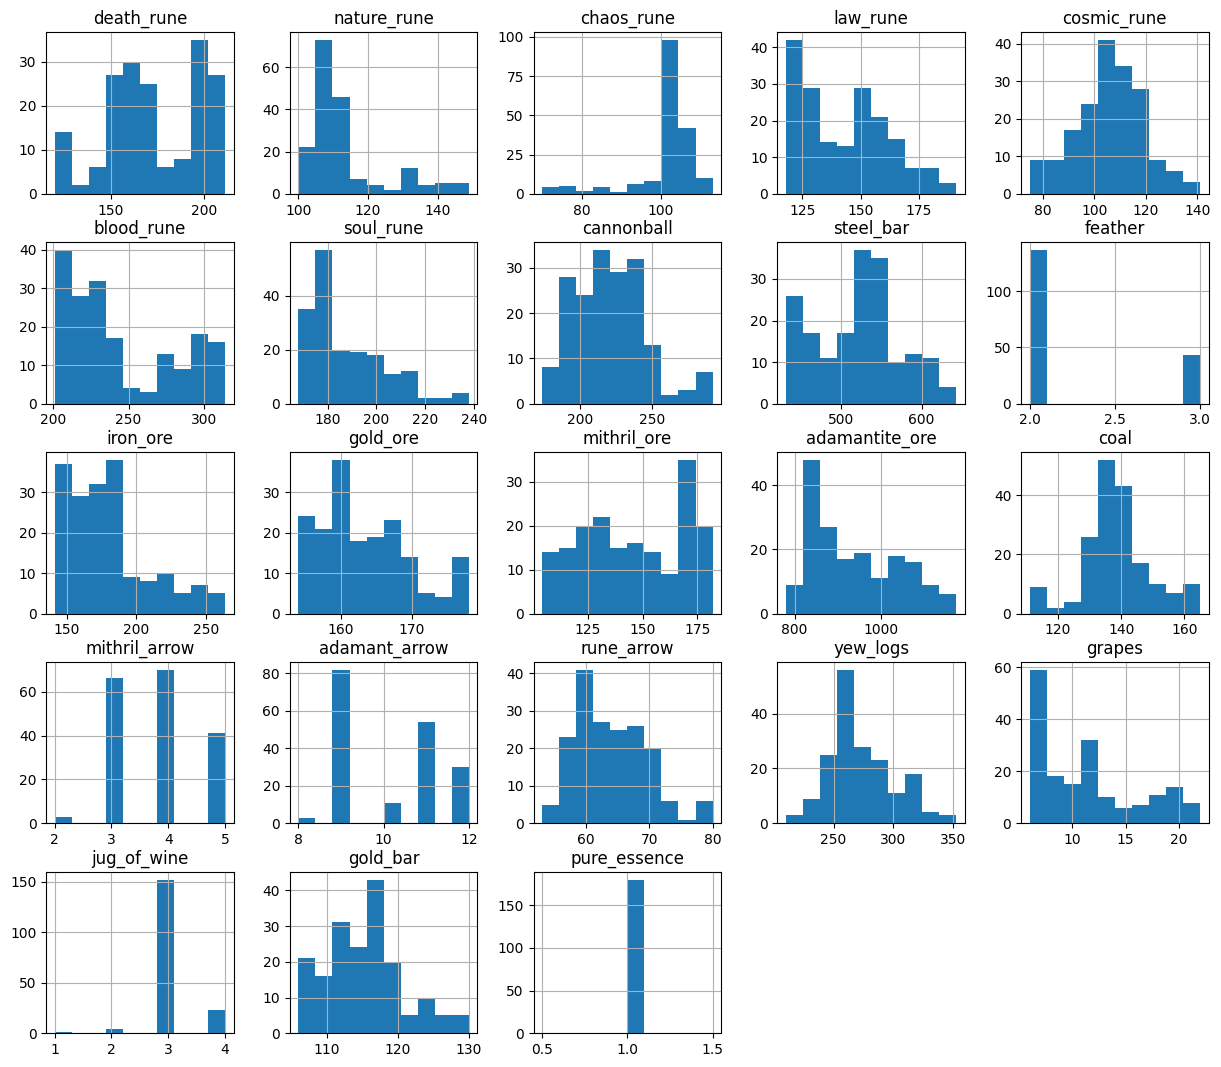

In [218]:
data.hist(figsize=(15,13))
plt.show()

Looking at the histogram above, pure essence, jug of wine, and feather doesn't seem to fluctuate in price very much. The number of trades that are set at only one price very high, meaning that is a very likely chance we will only be able to buy and trade at the same price, thus yielding no profit. We want an item that has a fairly evenly distributed prices so that we can capitalize on any price movements and make profit on it. Law runes, cannonballs, steel bars, gold bars, rune arrows, and death runes seem like good candidates; however, we will need further analysis to come to a conclusion.

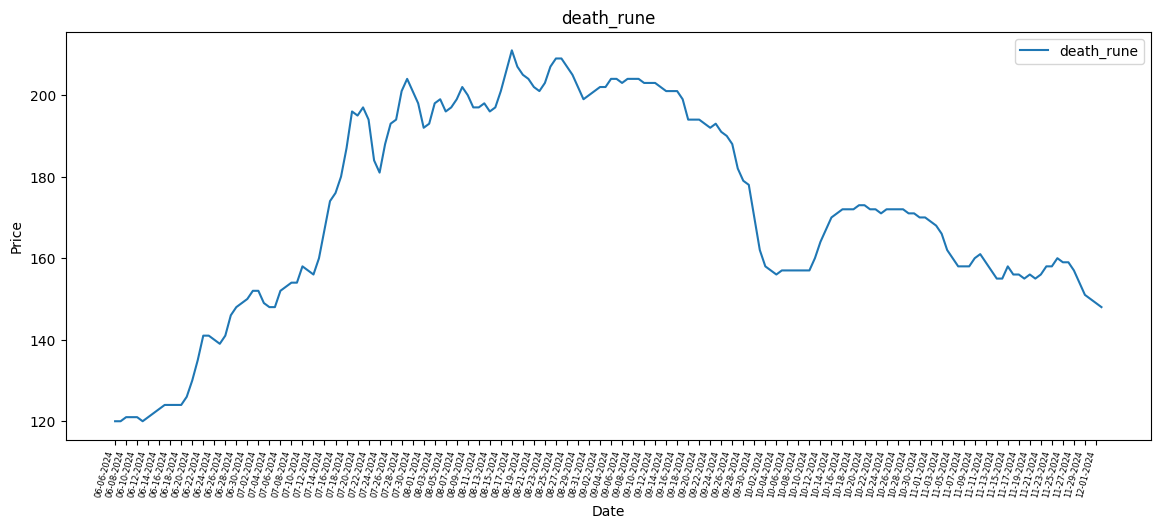

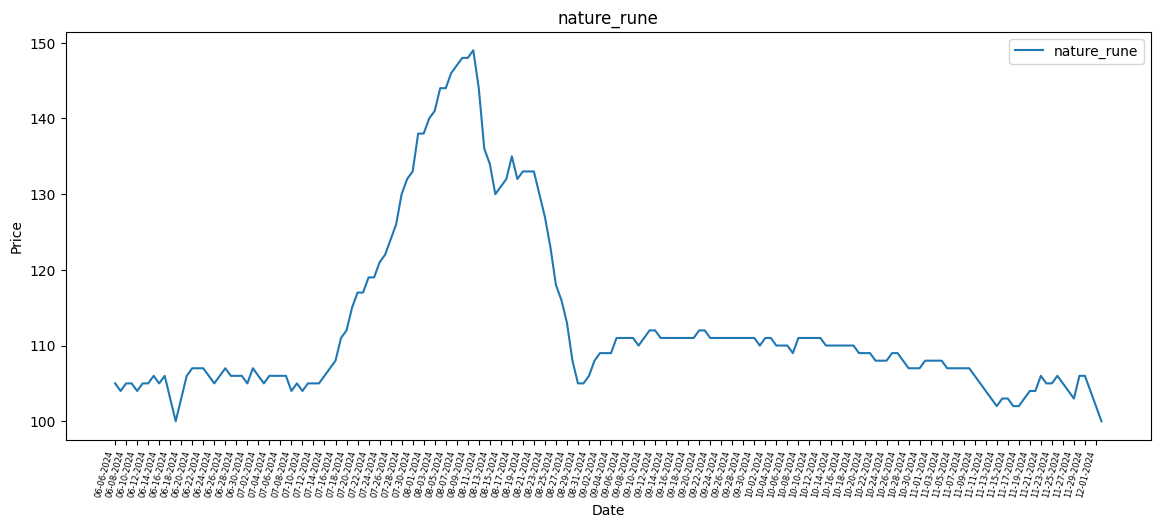

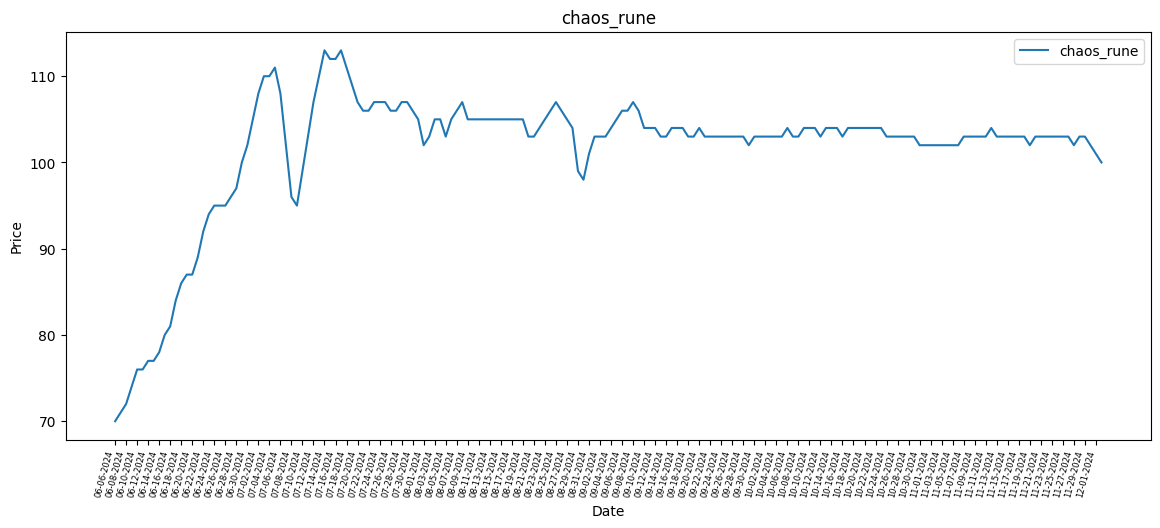

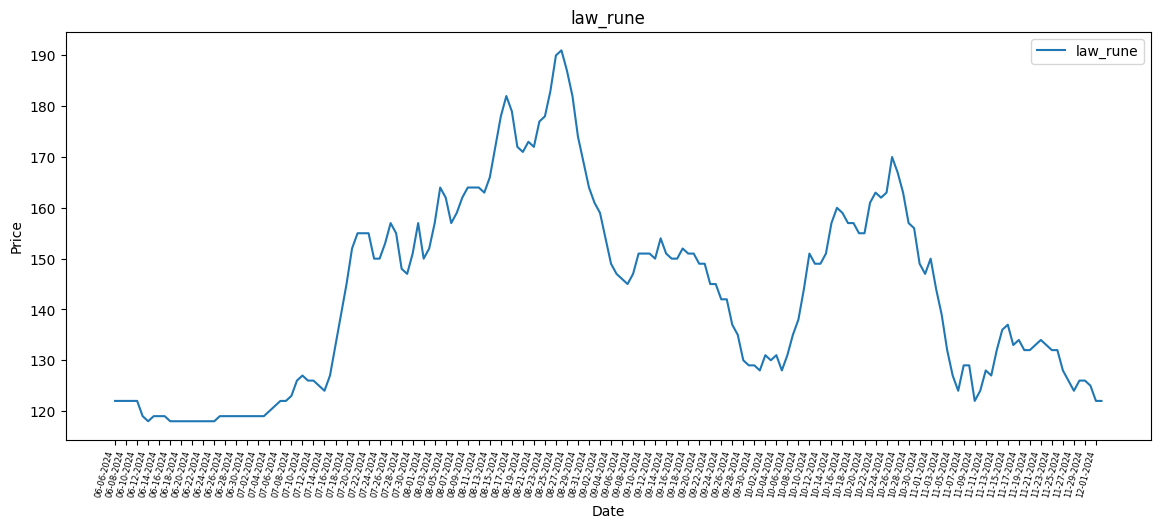

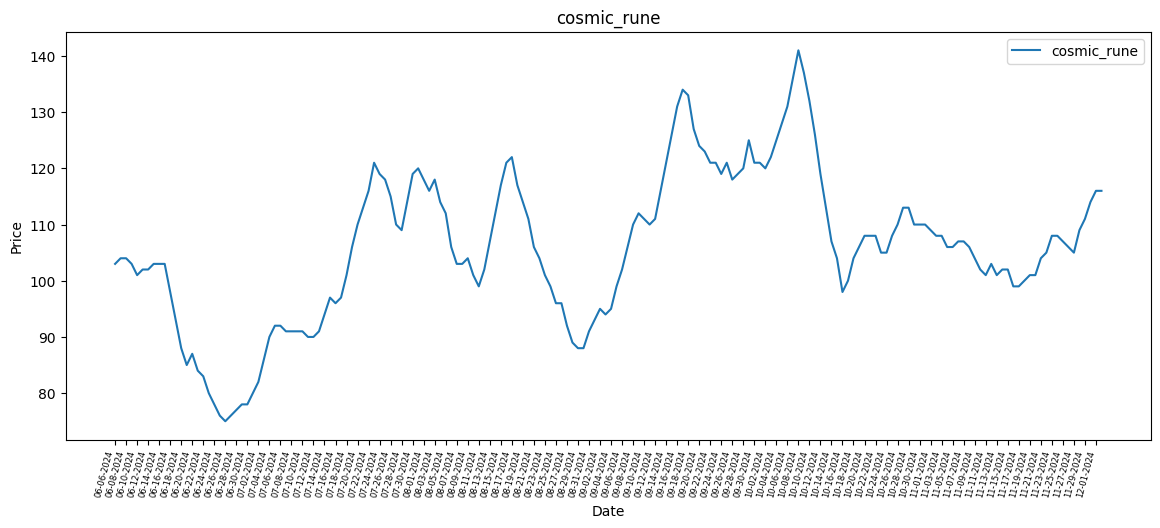

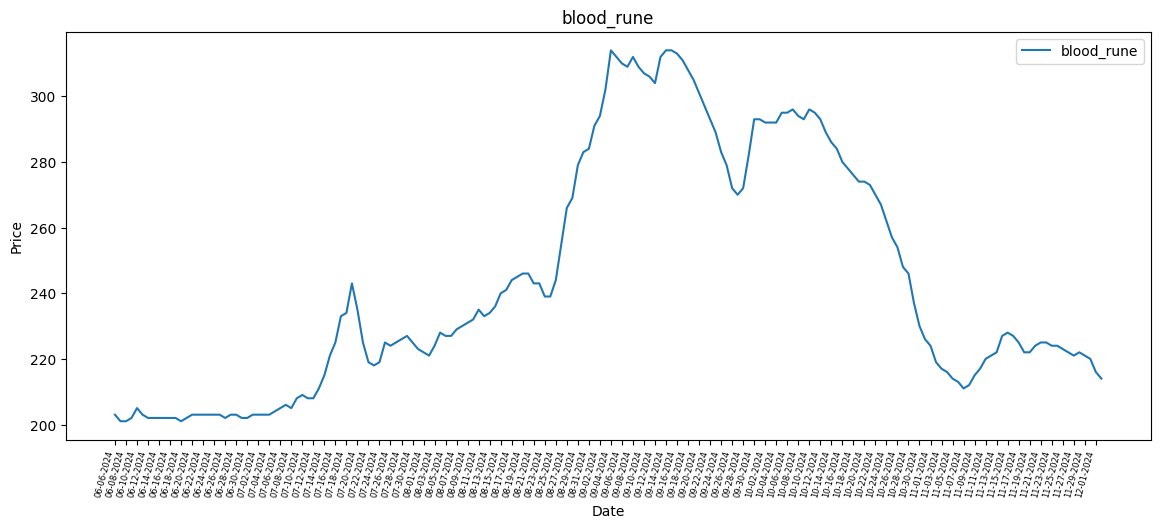

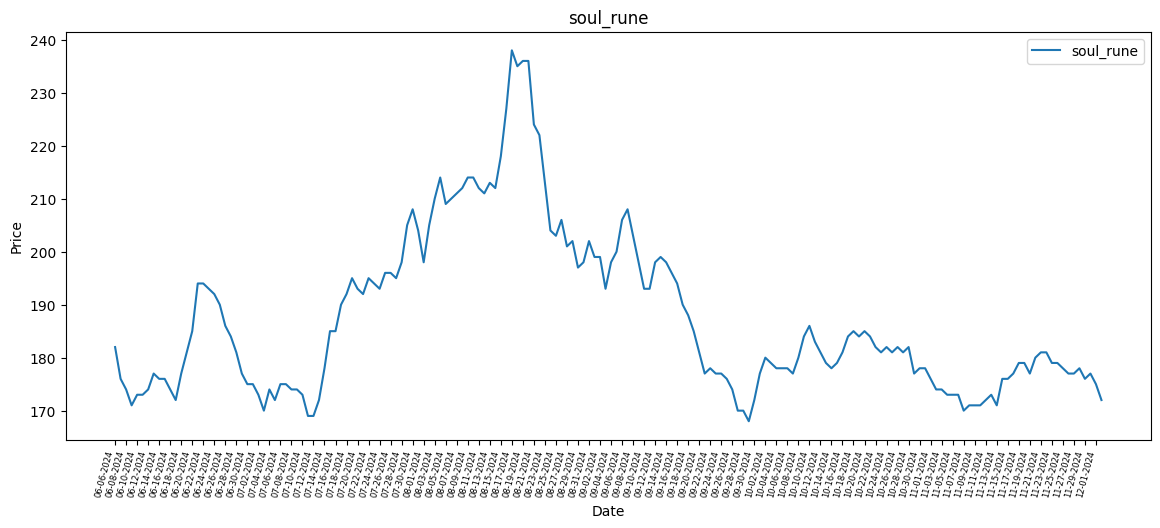

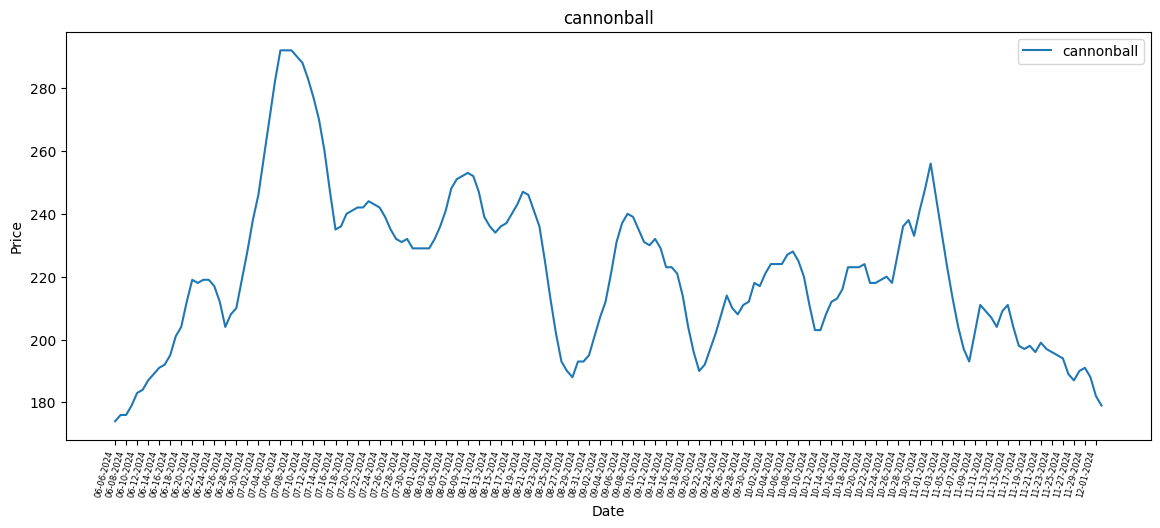

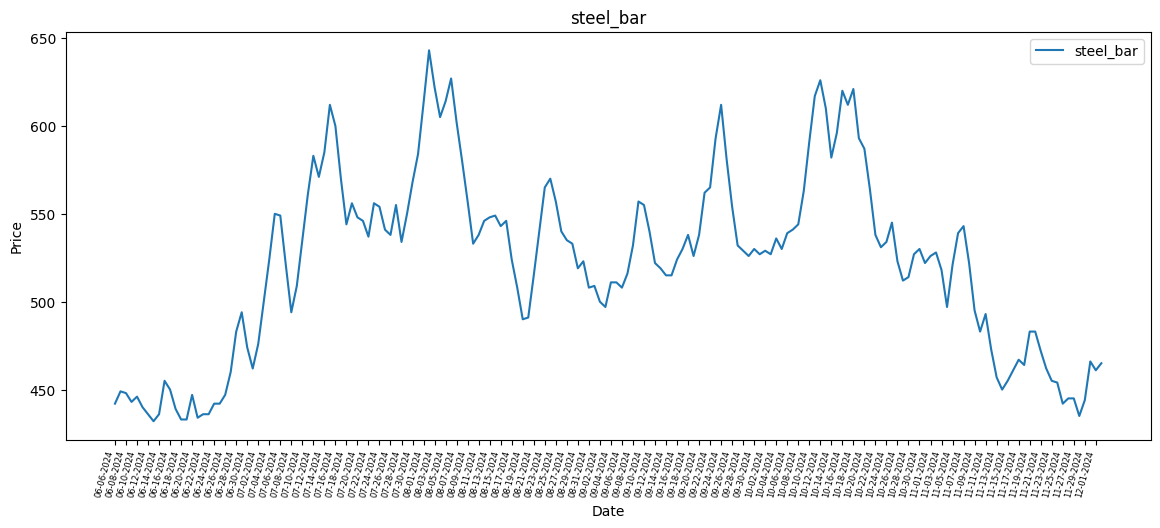

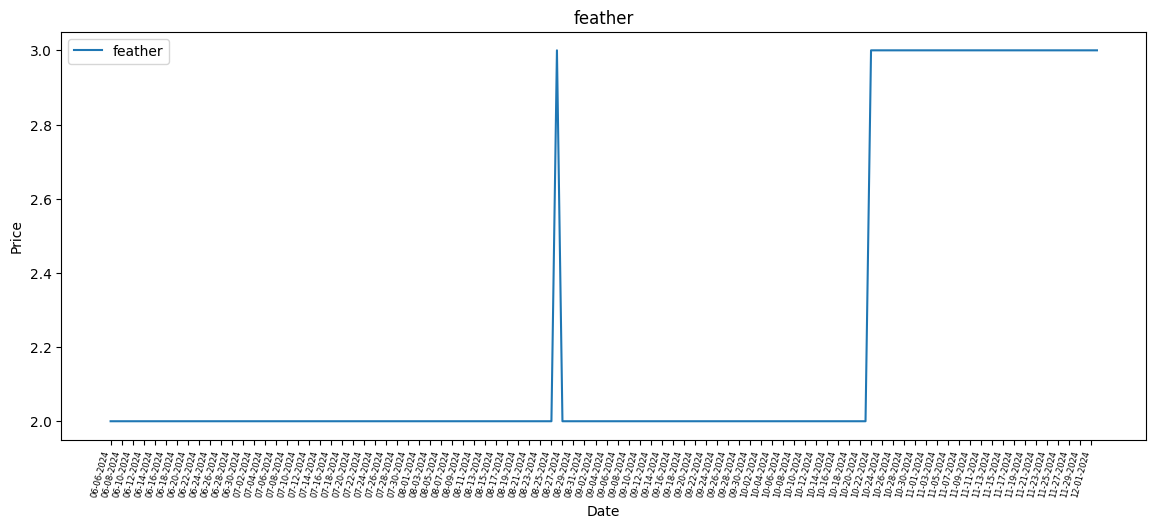

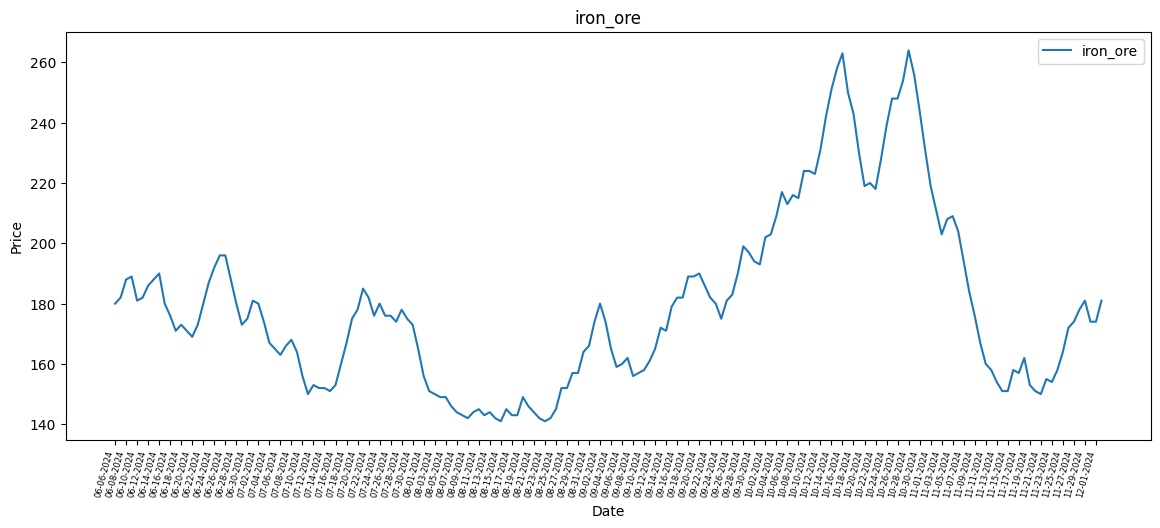

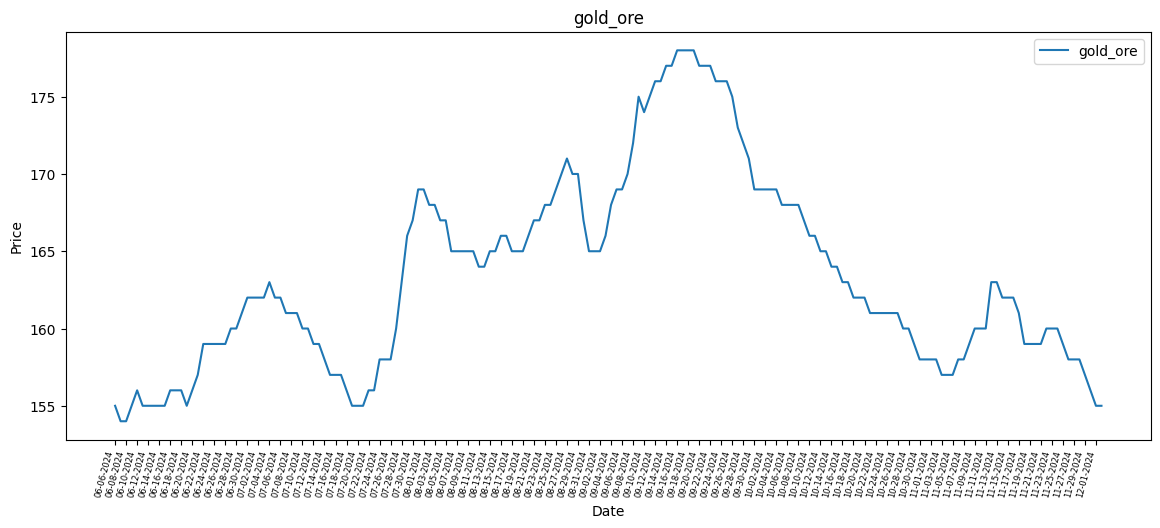

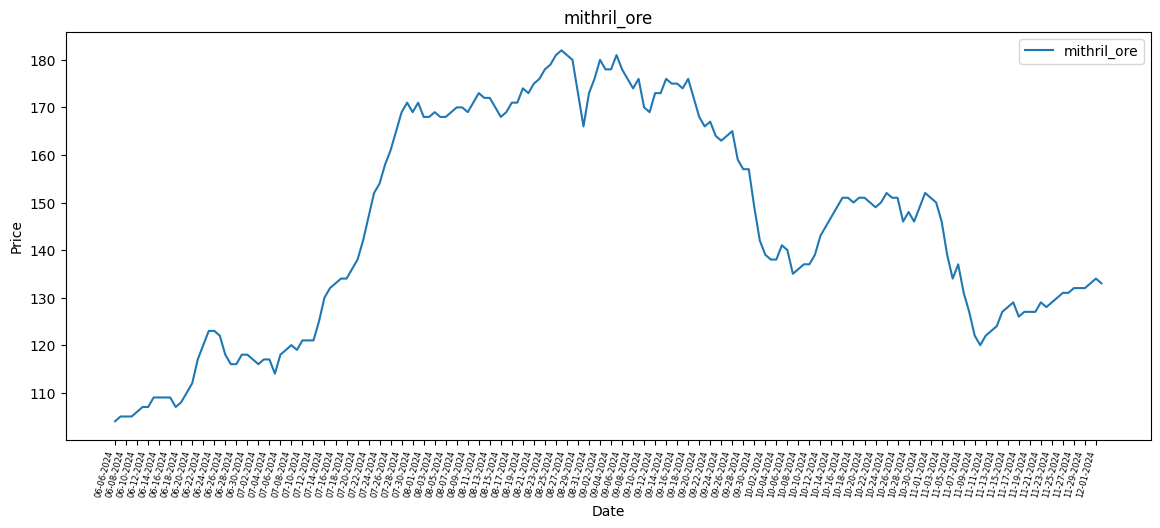

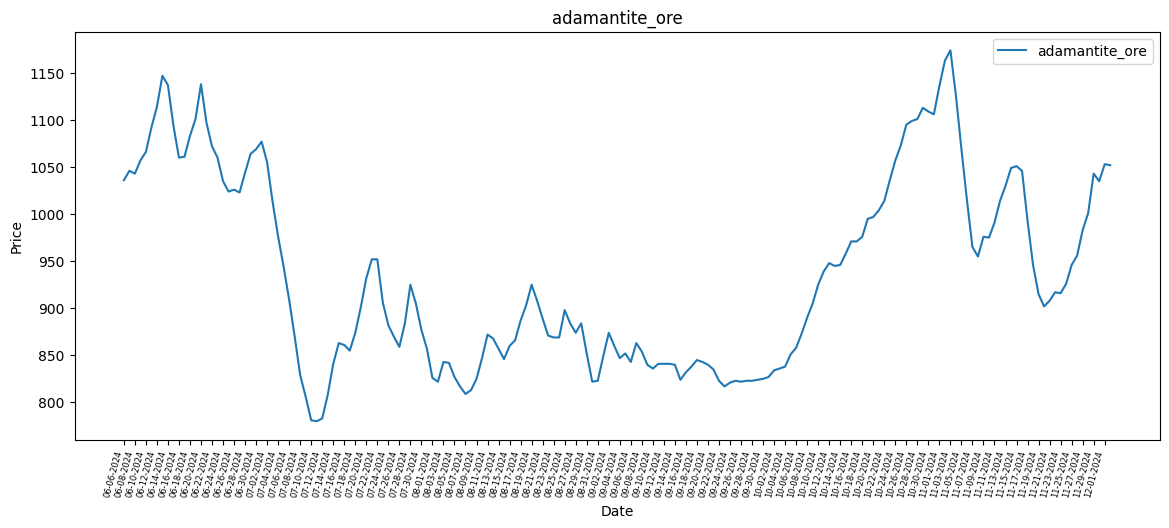

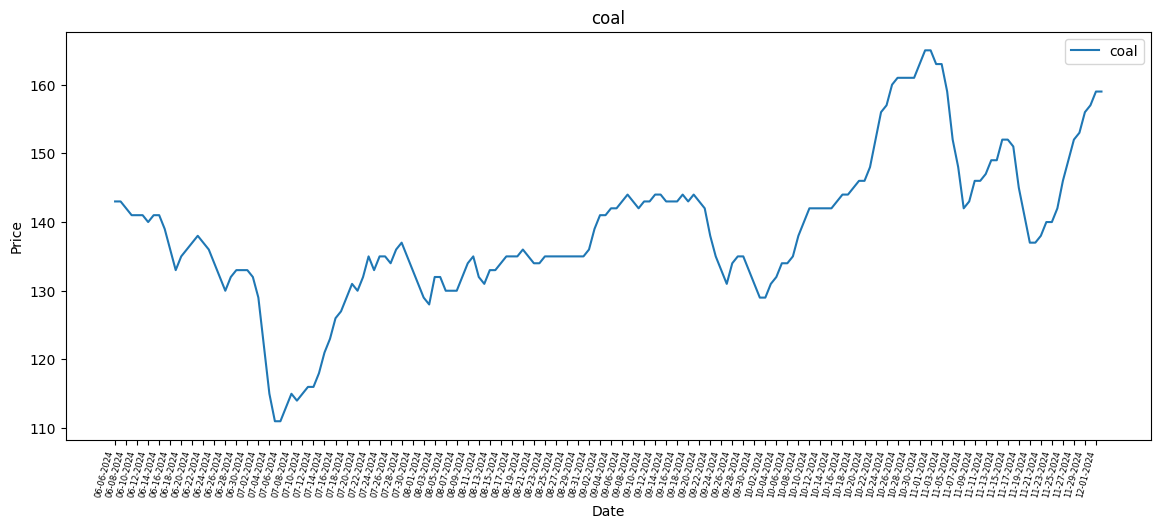

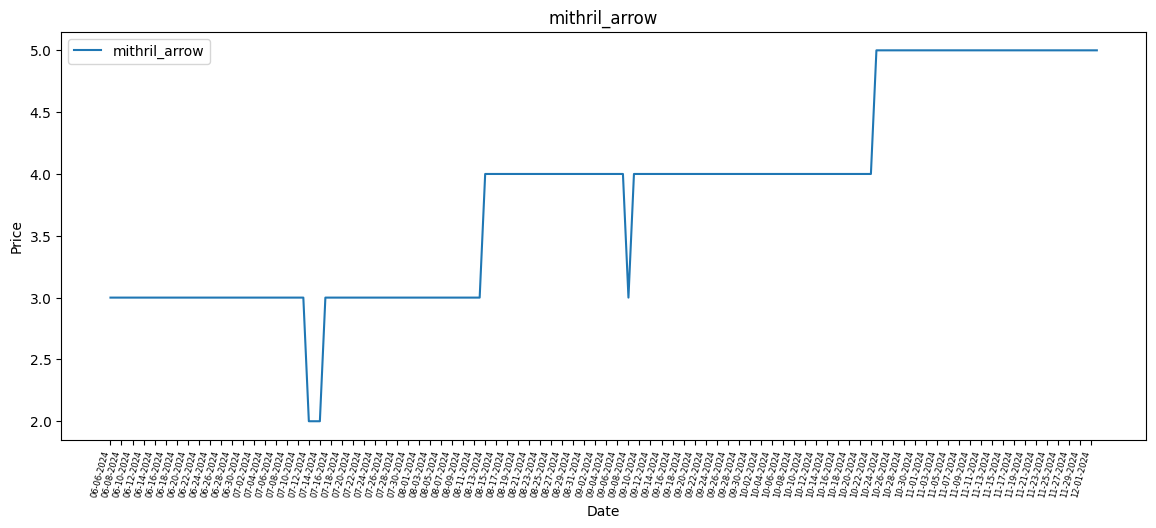

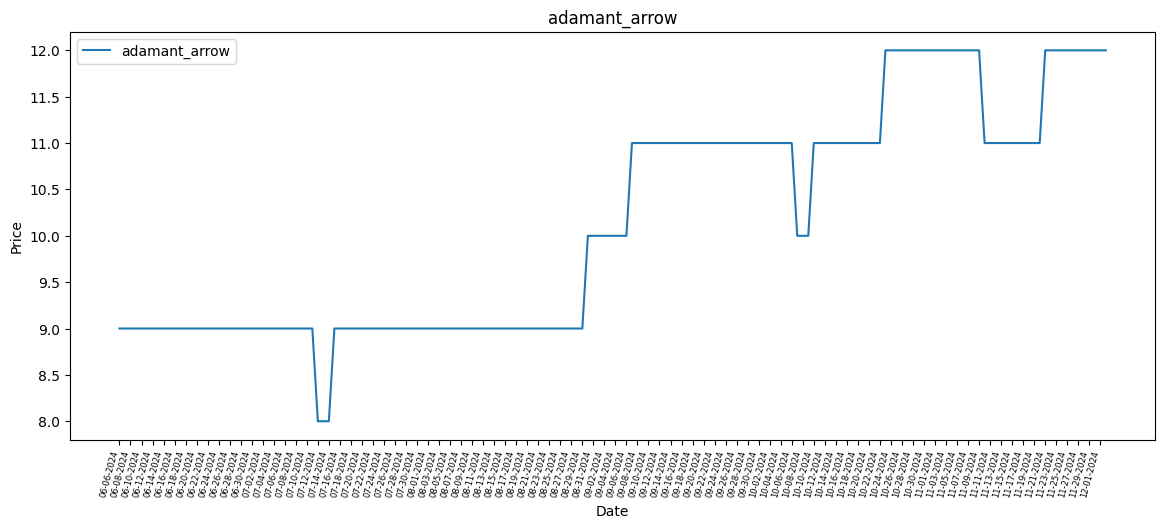

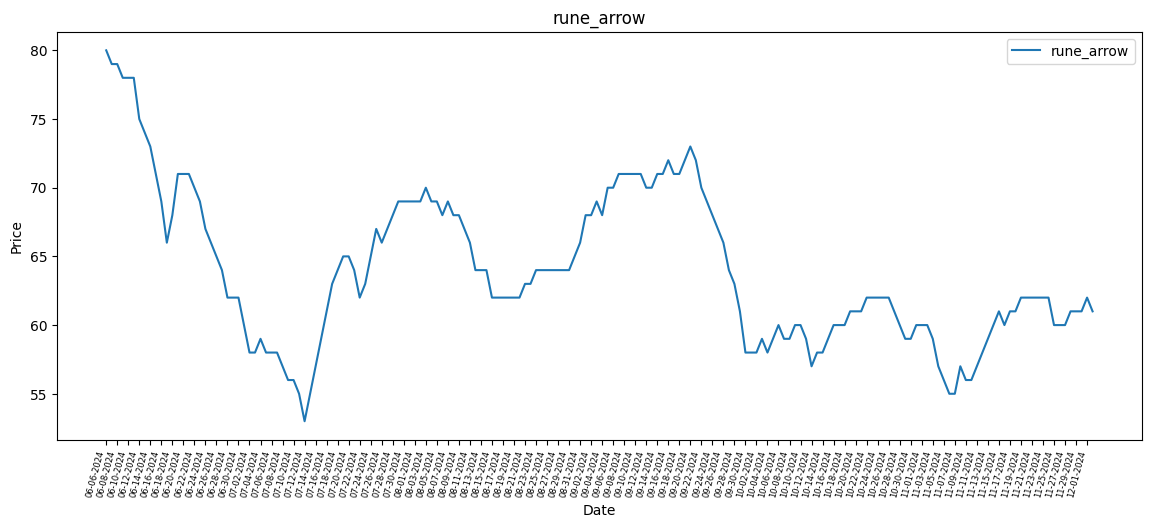

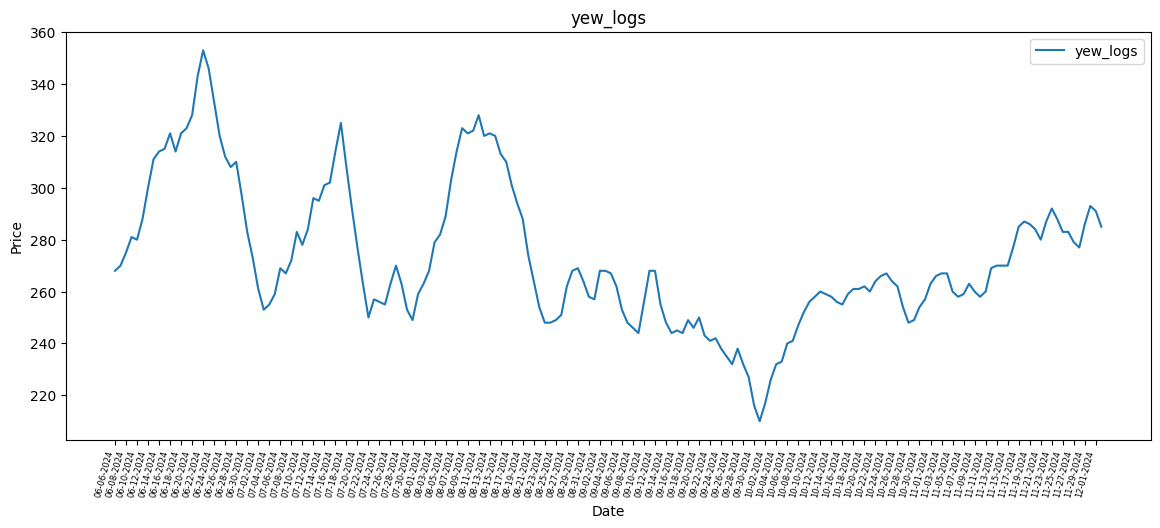

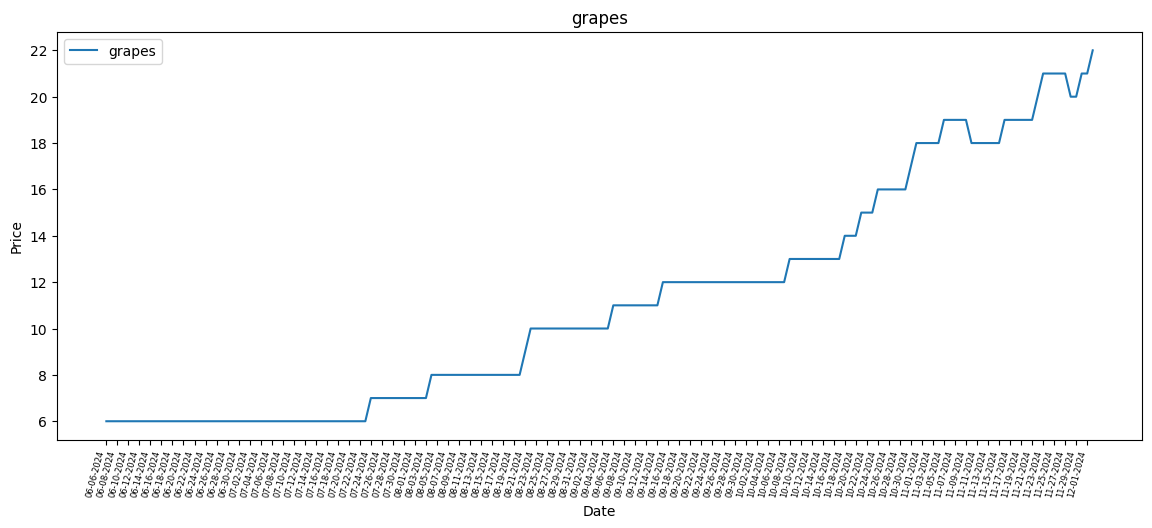

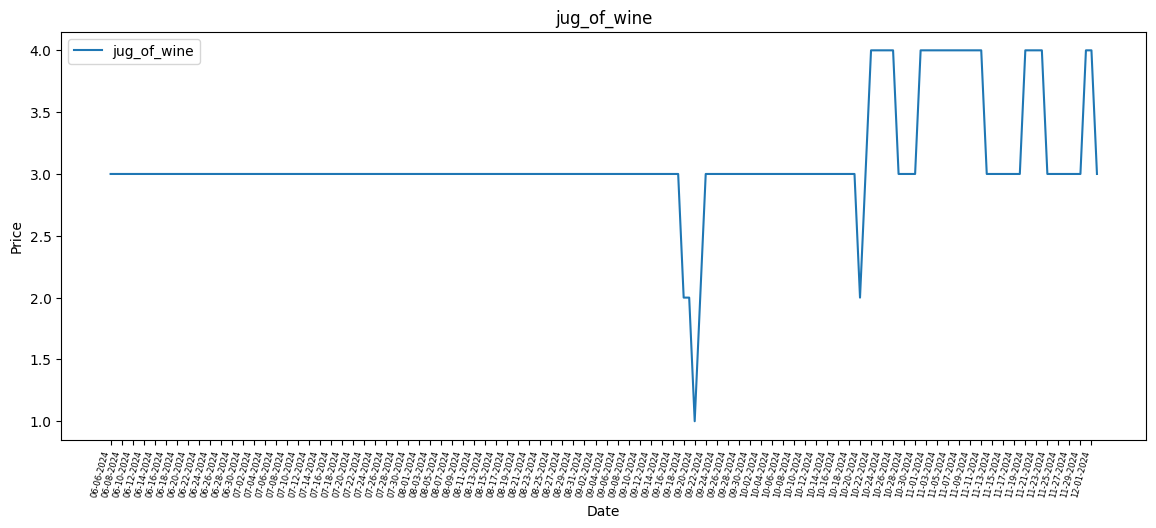

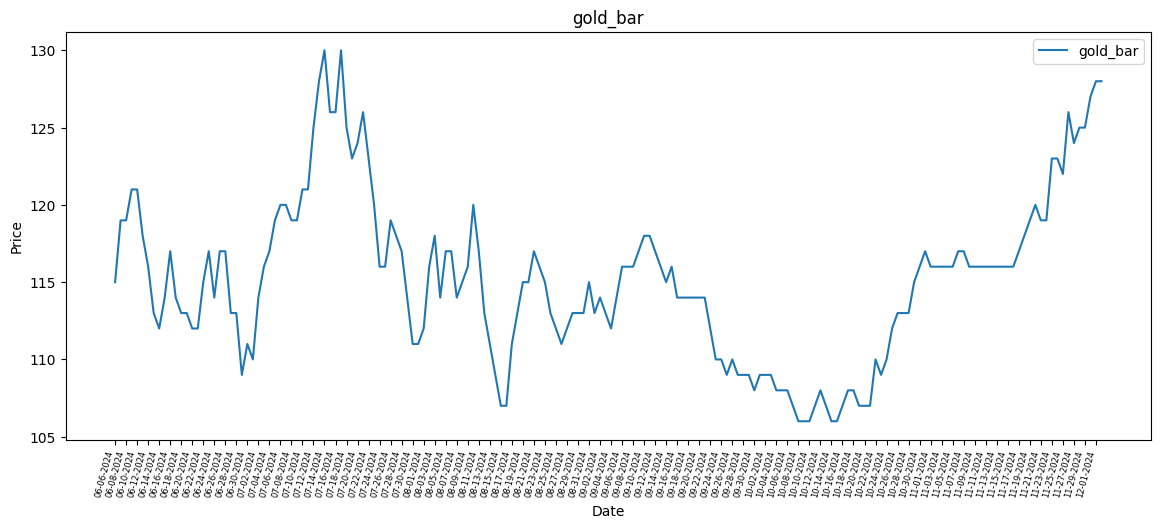

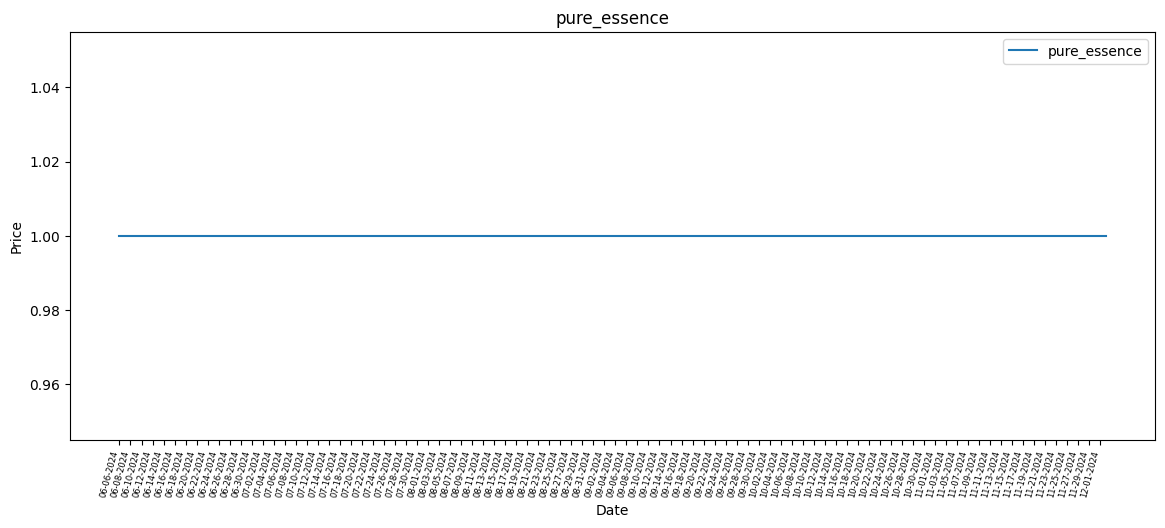

In [219]:


for column in data.columns:
    plt.figure(figsize=(14,6))
    tick_position = data.index[::2]
    plt.plot(data.index, data[column], label=column)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Adjust the interval as needed
    plt.gcf().autofmt_xdate()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(column)
    plt.legend()
    plt.xticks(rotation=75, ticks=tick_position, labels=tick_position, fontsize=6)
    plt.show()

Looking at the graphs above, there seems to be some outliers in jug of wine, and feather. Nature runes looks like it had some kind of major disruption from July to September. Pure essence doesn't seem to change. Previously, we already discussed that jug of wine, feather, and pure essence were already problematic. After looking at the graph, we can confirm that their lack of variability doesn't make them very profitable. We will thus drop them.  
  
On the other hand, cosmic runes, law runes, soul runes, cannon balls, steel bars, iron ore, yew logs, and gold bars looks like they have fairly high variability. Next, we will calculate the volatility by looking at the standard deviation of returns of each item.

In [220]:
df_dropped = data.drop(columns=['feather', 'jug_of_wine', 'pure_essence'])
print(df_dropped.columns)

Index(['death_rune', 'nature_rune', 'chaos_rune', 'law_rune', 'cosmic_rune',
       'blood_rune', 'soul_rune', 'cannonball', 'steel_bar', 'iron_ore',
       'gold_ore', 'mithril_ore', 'adamantite_ore', 'coal', 'mithril_arrow',
       'adamant_arrow', 'rune_arrow', 'yew_logs', 'grapes', 'gold_bar'],
      dtype='object')


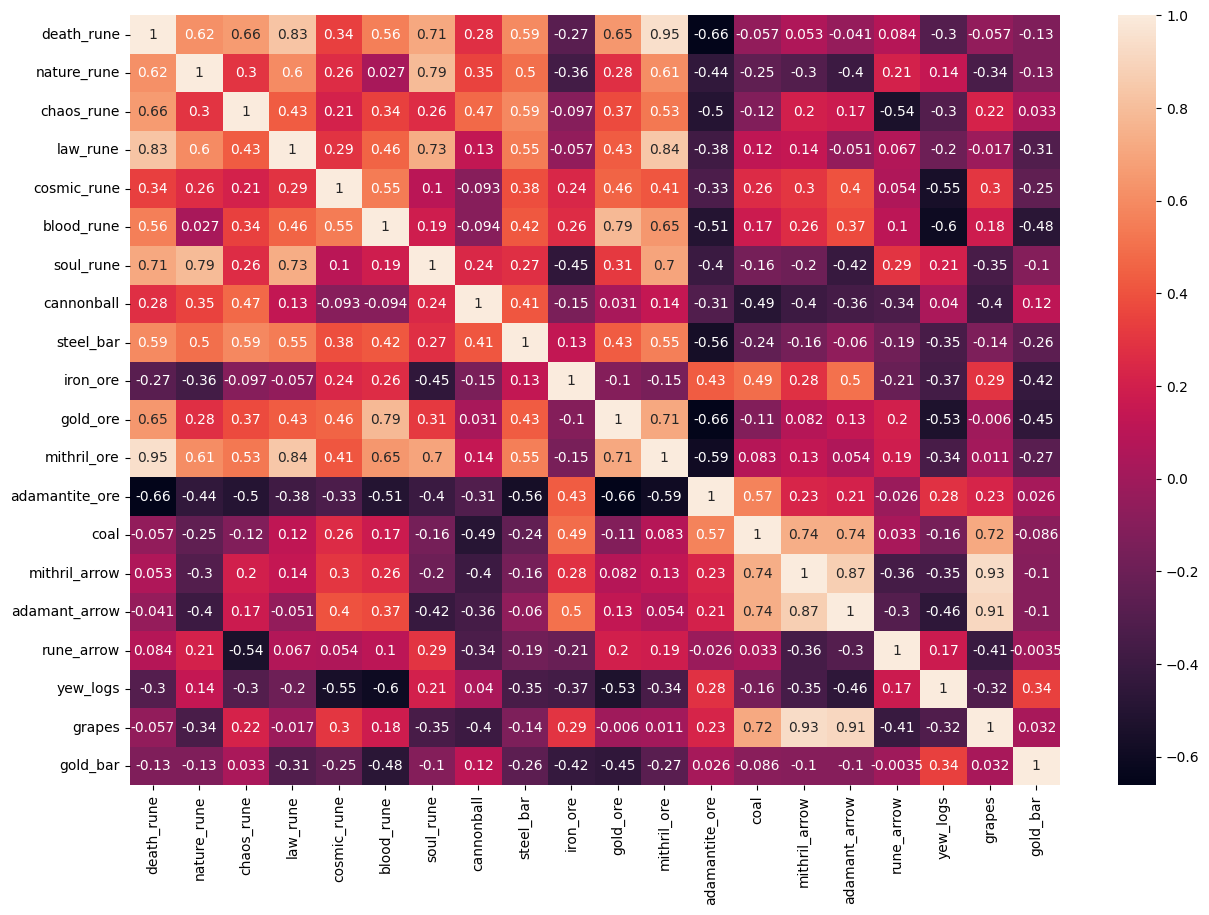

In [221]:
#correlation matrix
# normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_dropped)
normalized_df = pd.DataFrame(data, columns=df_dropped.columns)

corr_matrix = normalized_df.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=90)
plt.show()

In [222]:
returns = df_dropped.pct_change().dropna()
volatility = returns.std()
potential_profit = df_dropped.max() - df_dropped.min()
profit_df = pd.DataFrame({
    "Volatility": volatility,
    "Profit": potential_profit,
    "ProfitVolatility": volatility * potential_profit
})
profit_df_sorted = profit_df.sort_values(by="ProfitVolatility", ascending=False)
print(profit_df_sorted)

                Volatility  Profit  ProfitVolatility
adamantite_ore    0.021247     394          8.371367
steel_bar         0.028071     211          5.922894
iron_ore          0.029207     123          3.592411
yew_logs          0.024584     143          3.515567
cannonball        0.024016     118          2.833946
cosmic_rune       0.026566      66          1.753328
law_rune          0.021968      73          1.603689
blood_rune        0.014130     113          1.596638
death_rune        0.015846      91          1.442009
mithril_ore       0.017822      78          1.390110
soul_rune         0.016808      70          1.176542
coal              0.014956      54          0.807616
nature_rune       0.013651      49          0.668903
chaos_rune        0.014286      43          0.614295
rune_arrow        0.017568      27          0.474341
grapes            0.027539      16          0.440631
gold_bar          0.015664      24          0.375945
mithril_arrow     0.062910       3          0.

Above, we found the potential profit by subtracting the maximum price with the minimum, and the volatility by calculating the percentage change and the corresponding standard deviation. We then multiplied the volatility with the profit to produce a metric that could indicate an item that has high risk but also high rewards. Adamintite ore, steel bar, iron ore, and yew logs seem to be good candidates to train our model on.  
We will start off with the steel bar since the steel bar is very profitable and has a higher volatility, meaning there are more chances to make profit.  

Next up, we will need to enrich and clean our data. We want to predict the prices for an x number of days into the future using past data; however, we only have 180 days worth of data and our data is sequential. We should not be using any data that comes after our target. Meaning, each target would have a different number of predictors. For example, if our model was trying to predict day 180 and day 170, day 180 would have 179 predictors but day 170 would only have 169 predictors. This is an issue since we need all X's to be of the same shape. To solve this, we will limit the number of days that the model can look back to. Any X's with missing data, will be dropped.  

In [ ]:
def lag_features(data, target_item, feature_count, num_days_to_predict):
    X, y = [], []
    for item in target_item:
        item_prices = data[item]
        for i in range(feature_count, len(item_prices) - num_days_to_predict):
            tempX = list(item_prices[i-feature_count: i])
            tempY = list(item_prices[i: i + num_days_to_predict])
            X.append(tempX)
            y.append(tempY)
    X = pd.DataFrame(X, columns=[f"past_day_{j+1}" for j in range(feature_count)])
    y = pd.DataFrame(y, columns=[f"target_day_{k+1}" for k in range(num_days_to_predict)])
    return X, y

def add_rolling_stats(df):
    df = df.copy()
    df.loc[:,"rolling_mean"] = df.mean(axis=1)
    return df

# Model Analysis  
Our target is a numerical attribute, so we should use a regression analysis. We will try and compare a linear regression, support vector regression, and random forest tree regression.  

For now, we will only be looking at the data for adamantite_ore.  
  
When splitting, we also need to take into account that we are dealing with a time series. We must preserve the order and cannot randomly split because that would result in data leakage since the data from the test might be the data for a training feature if the training feature is from the future.

In [235]:
# First split_factor% (e.g. 80%) goes to train, rest is test
def split_data(X, y, split_factor):
    split_index_X = int(split_factor * len(X))
    split_index_y = int(split_factor * len(y))
    X_train = X.iloc[:split_index_X,]
    X_test = X.iloc[split_index_X:,]
    y_train = y.iloc[:split_index_y]
    y_test = y.iloc[split_index_y:]
    return X_train, X_test, y_train, y_test

def score(p, y_test, y_pred):
    # mse and r2
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test) # number of observations
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    print("MSE: ", mse)
    print(f"R2: {r2}")
    print(f"r2 adjusted: {r2_adj}")
    return mse, r2, r2_adj

def enrich_and_split(df, feature_count, num_days_to_predict, target_items):
    X, y = lag_features(df, target_items, feature_count, num_days_to_predict)
    draw_corr_matrix(pd.concat([X, y], axis=1))
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

    X_train = add_rolling_stats(X_train)
    X_test = add_rolling_stats(X_test)

    return X_train, X_test, y_train, y_test

def draw_corr_matrix(data):
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

    corr_matrix = normalized_df.corr()

    plt.figure(figsize=(10,5))
    sns.heatmap(corr_matrix, annot=True)
    plt.xticks(rotation=90)
    plt.show()

# Predicting 1 day into the future  
We will start by enriching our data and finding our X and y. Enrich data will split the data into windows of feature_count past days. X will be the historical prices used to predict our target, y. We will thens split the data into our testing and training sets. The split is done sequentially to not disturb the chronological order of our time series meaning that the trainig data will be the first 80% and our testing will be the last 20%. After we split the data, we will be enriching them once again with rolling means. This is done after the splitting to ensure that there will be no data leakage.  
  
We will train the model using adamantite_ore. After, we will test the model with steel_bar. We want to see if the model is able to fit other items and that it is not overfitting to adamantite_ore. 

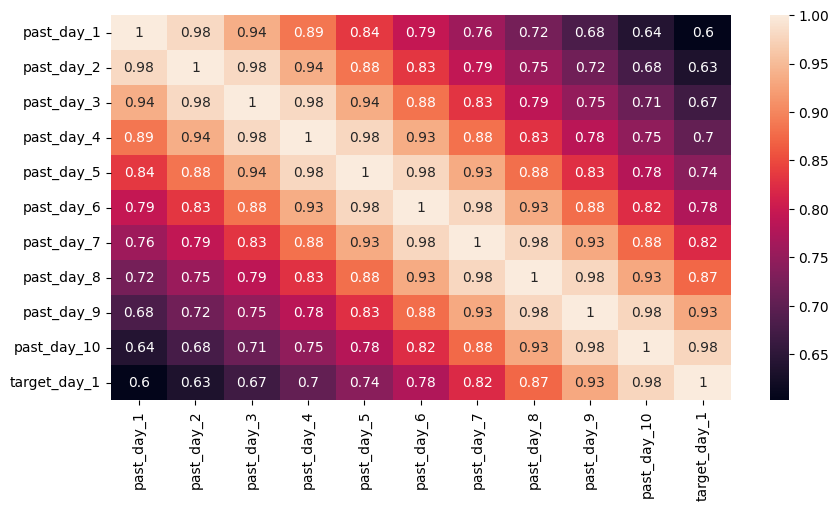

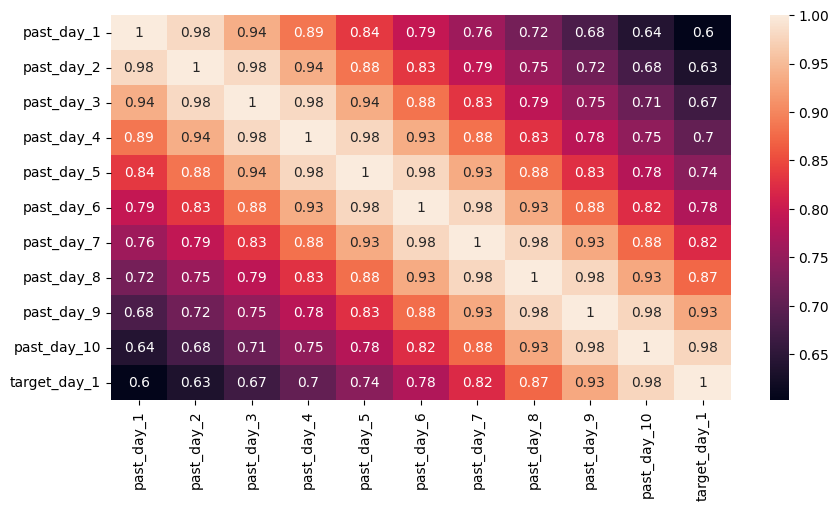

In [225]:
feature_count = 10
num_days_to_predict = 1
target_item = ["adamantite_ore"]
X_train, X_test, y_train, y_test = enrich_and_split(data, feature_count, num_days_to_predict, target_item)
X_train_nor, X_test_nor, y_train_nor, y_test_nor = enrich_and_split(normalized_df, feature_count, num_days_to_predict, target_item)

In [227]:
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)
lin_mse, lin_r2, lin_r2_adj = score(X_train.shape[1], y_test, lin_y_pred)

MSE:  424.5623009327773
R2: 0.926388077861261
r2 adjusted: 0.8895821167918915


In [228]:
# Ridge
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
ridge_y_pred = ridge_model.predict(X_test)
ridge_mse, ridge_r2, ridge_r2_adj = score(X_train.shape[1], y_test, ridge_y_pred)


MSE:  429.60588176065767
R2: 0.9255136062504122
r2 adjusted: 0.8882704093756184


Poly kernel was not tested due to time constraints

In [229]:
svr_param_grid = {
    "C":[0.1, 1, 10, 100],
    "kernel":["linear","rbf","sigmoid"],
    "gamma":[0.001,0.01,1],
    "degree":[2,3]
}

# Support Vector
svr_model = SVR()
grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=5, n_jobs=-1, scoring="r2")
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_svr = grid_search.best_estimator_
print(best_params)

svr_y_pred = best_svr.predict(X_test)
svr_mse, svr_r2, svr_r2_adj = score(X_train.shape[1], y_test, svr_y_pred)


{'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}
MSE:  412.5181980462769
R2: 0.9284763215936042
r2 adjusted: 0.8927144823904063


c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [230]:
param_grid = {
    "n_estimators": [1,2,3,5,10,20],
    "max_depth": [i for i in range(1, 20, 1)],
    "max_features": ["auto", "sqrt", "log2", feature_count]
}

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring="r2")
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print(best_params)

rf_y_pred = best_rf.predict(X_test)
rf_mse, rf_r2, rf_r2_adj = score(X_train.shape[1], y_test, rf_y_pred)


{'max_depth': 9, 'max_features': 10, 'n_estimators': 2}
MSE:  2891.6838235294117
R2: 0.49863093355243193
r2 adjusted: 0.2479464003286478


c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
570 fits failed out of a total of 2280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
358 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate

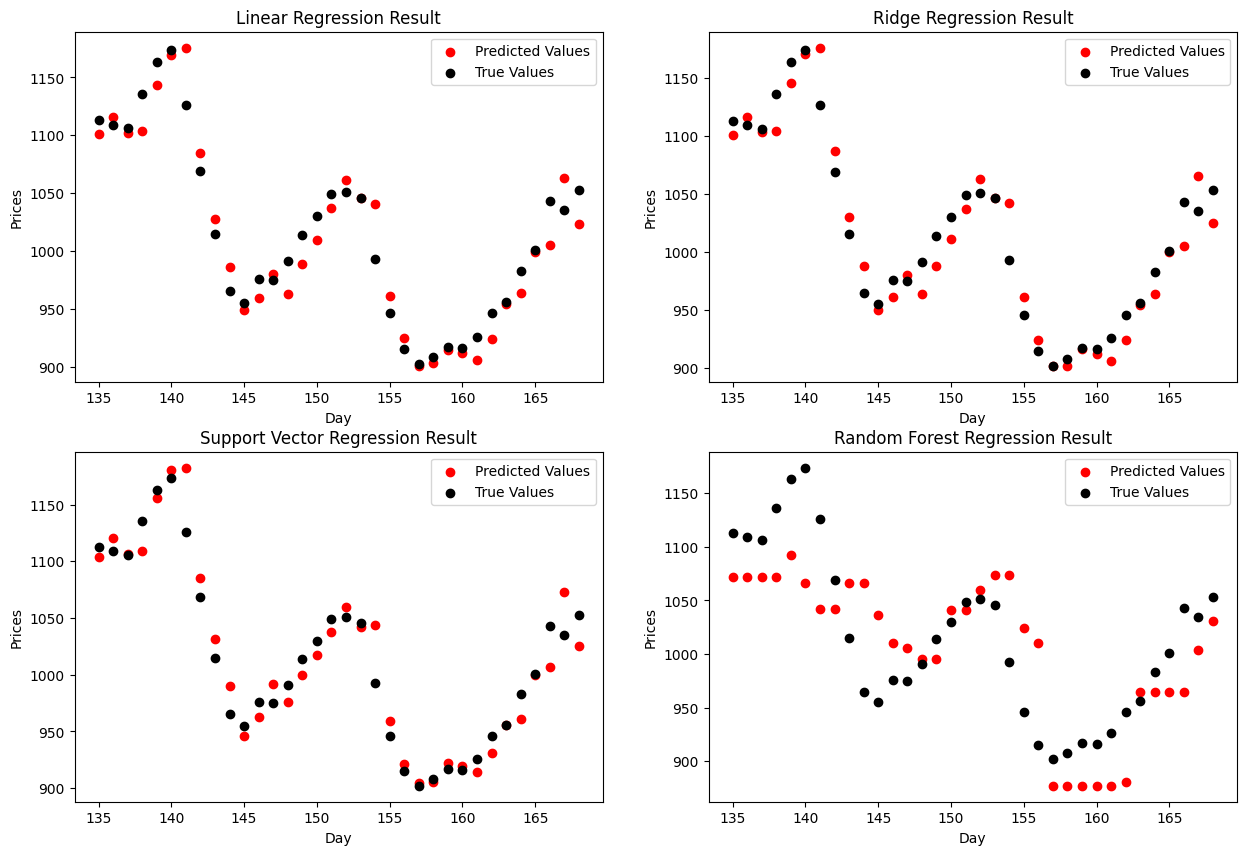

In [231]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Linear
axs[0,0].scatter(y_test.index, lin_y_pred, label="Predicted Values", color="red")
axs[0,0].scatter(y_test.index, y_test, label="True Values", color="black")
axs[0,0].set_xlabel("Day")
axs[0,0].set_ylabel("Prices")
axs[0,0].set_title("Linear Regression Result")
axs[0,0].legend()

# Ridge
axs[0,1].scatter(y_test.index, ridge_y_pred, label="Predicted Values", color="red")
axs[0,1].scatter(y_test.index, y_test, label="True Values", color="black")
axs[0,1].set_xlabel("Day")
axs[0,1].set_ylabel("Prices")
axs[0,1].set_title("Ridge Regression Result")
axs[0,1].legend()

# SVR
axs[1,0].scatter(y_test.index, svr_y_pred, label="Predicted Values", color="red")
axs[1,0].scatter(y_test.index, y_test, label="True Values", color="black")
axs[1,0].set_xlabel("Day")
axs[1,0].set_ylabel("Prices")
axs[1,0].set_title("Support Vector Regression Result")
axs[1,0].legend()

# Random Forest
axs[1,1].scatter(y_test.index, rf_y_pred, label="Predicted Values", color="red")
axs[1,1].scatter(y_test.index, y_test, label="True Values", color="black")
axs[1,1].set_xlabel("Day")
axs[1,1].set_ylabel("Prices")
axs[1,1].set_title("Random Forest Regression Result")
axs[1,1].legend()

plt.tight_layout
plt.show()

Our analysis of one step predictions results in our linear, ridge, and svr using a linear kernel being the most accurate with an r2 adjusted of about 0.88. Random Forest Tree, the only model that wasn't linear, scored an r2_adjusted of 0.24. Because all of the models we tested were linear in nature performed well, there is strong indication that there is a strong linear relationship between the predictors and the target variable. Random Forest showing a lower r2 adjusted suggests that it is not the best fit for this dataset, probably due to overfitting.  
  
Next, we'll try to predict the next 7 days rather than just one day.

Linear  
    MSE:  424.5623009327773  
    R2: 0.926388077861261  
    r2 adjusted: 0.8895821167918915  
  
Ridge  
    MSE:  429.60588176065767  
    R2: 0.9255136062504122  
    r2 adjusted: 0.8882704093756184  
  
SVR  
    MSE:  433.2297886737537  
    R2: 0.9248852820847038  
    r2 adjusted: 0.8873279231270557  
  
RF  
    MSE:  2891.6838235294117  
    R2: 0.49863093355243193  
    r2 adjusted: 0.2479464003286478   

# Predicting 7 days into the future

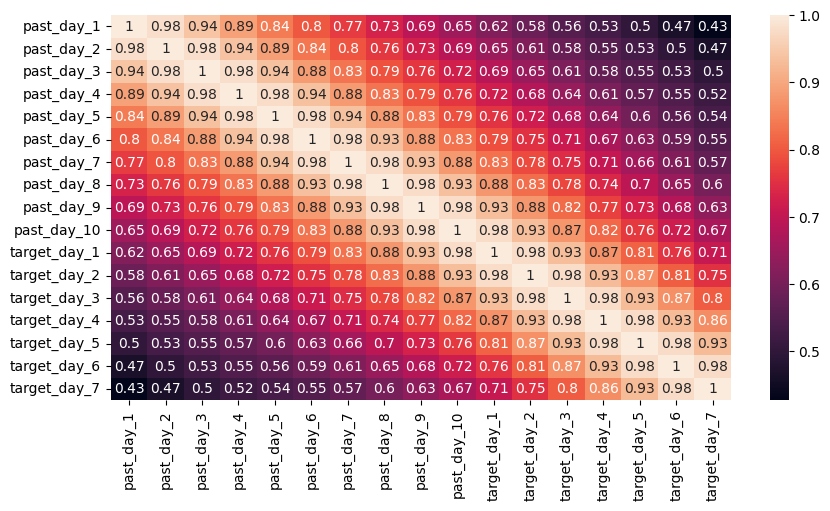

In [232]:
feature_count = 10
num_days_to_predict = 7

target_item = ["adamantite_ore"]
X_train_7, X_test_7, y_train_7, y_test_7 = enrich_and_split(data, feature_count, num_days_to_predict, target_item)

In [233]:
# Linear
lin_model_7 = LinearRegression()
lin_model_7.fit(X_train_7, y_train_7)
lin_y_pred_7 = lin_model_7.predict(X_test_7)
print(f"\nLinear")
lin_mse_7, lin_r2_7, lin_r2_adj_7 = score(X_train_7.shape[1], y_test_7, lin_y_pred_7)

# Ridge
ridge_models = []
for day in range(num_days_to_predict):
    ridge_model = Ridge(alpha=0.1)
    ridge_model.fit(X_train_7, y_train_7.iloc[:, day])
    ridge_models.append(ridge_model)

ridge_y_pred = np.zeros((X_test_7.shape[0], num_days_to_predict))
for day, ridge_model in enumerate(ridge_models):
    ridge_y_pred[:, day] = ridge_model.predict(X_test_7)
print(f"\nRidge")
ridge_mse, ridge_r2, ridge_r2_adj = score(X_train_7.shape[1], y_test_7, ridge_y_pred)

# SVR
svr_models = []
for day in range(num_days_to_predict):
    svr_model = SVR(C=2, kernel="linear")
    svr_model.fit(X_train_7, y_train_7.iloc[:, day])
    svr_models.append(svr_model)

svr_y_pred = np.zeros((X_test_7.shape[0], num_days_to_predict))
for day, svr_model in enumerate(svr_models):
    svr_y_pred[:, day] = svr_model.predict(X_test_7)
print(f"\nSVR")
svr_mse, svr_r2, svr_r2_adj = score(X_train_7.shape[1], y_test_7, svr_y_pred)

# RF
param_grid = {
    "n_estimators": [1,5,10,100],
    "max_depth": [i for i in range(1, 50, 10)],
    "max_features": ["auto", "sqrt", "log2"],
    "ccp_alpha": np.linspace(0.1, 1.0, 5).tolist()
}
rf_model_7 = RandomForestRegressor(random_state=42)
grid_search_7 = GridSearchCV(estimator=rf_model_7, param_grid=param_grid, cv=5, n_jobs=-1, scoring="r2")
grid_search_7.fit(X_train_7, y_train_7)

best_params = grid_search_7.best_params_
best_rf_7 = grid_search_7.best_estimator_
rf_y_pred_7 = best_rf_7.predict(X_test_7)
print(f"\nRandom Forest")
rf_mse_7, rf_r2_7, rf_r2_adj_7 = score(X_train_7.shape[1], y_test_7, rf_y_pred_7)


Linear
MSE:  5762.973818631895
R2: 0.04178603210753835
r2 adjusted: -0.46013557012184636

Ridge
MSE:  5762.977777112744
R2: 0.041785410589442726
r2 adjusted: -0.46013651719703974

SVR
MSE:  6710.76429826418
R2: -0.1179319961614462
r2 adjusted: -0.7035154227222038

Random Forest
MSE:  11197.526709956712
R2: -0.8434912444661196
r2 adjusted: -1.8091295153769442


c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
274 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Anthony\Desktop\Project\School\CSCA5622\w7\grand-exchange-price-predictor\.venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate

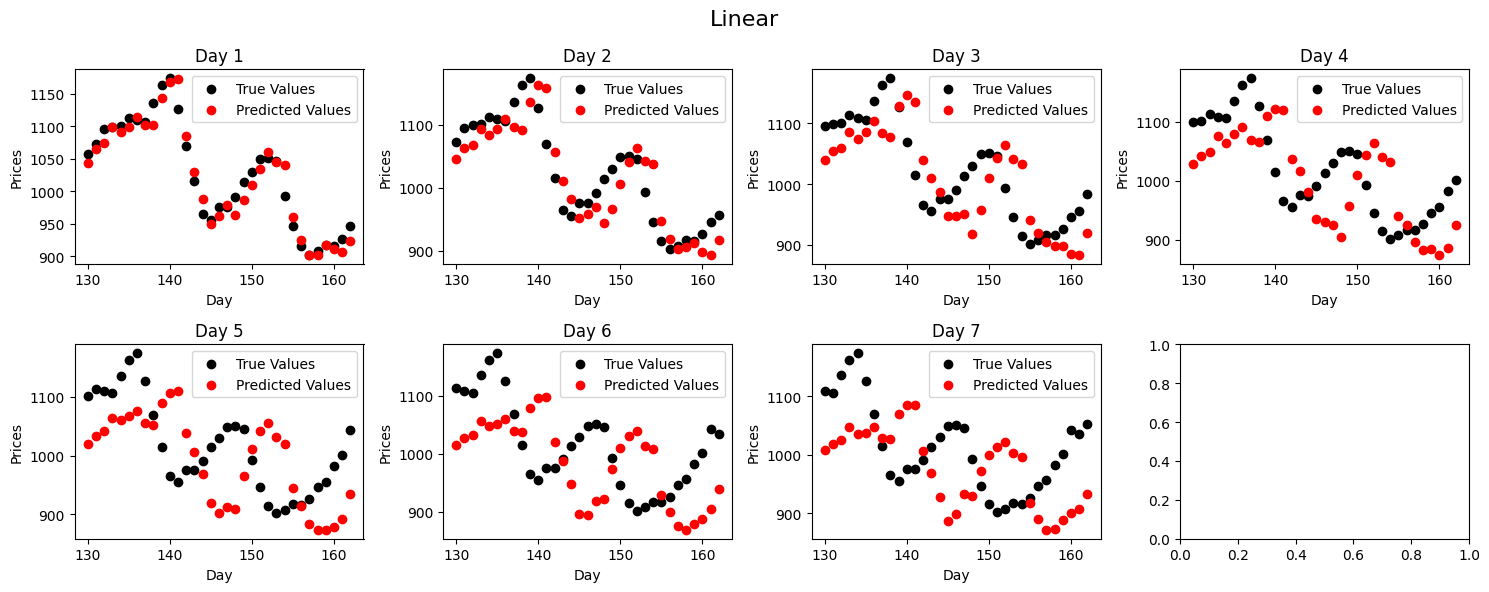

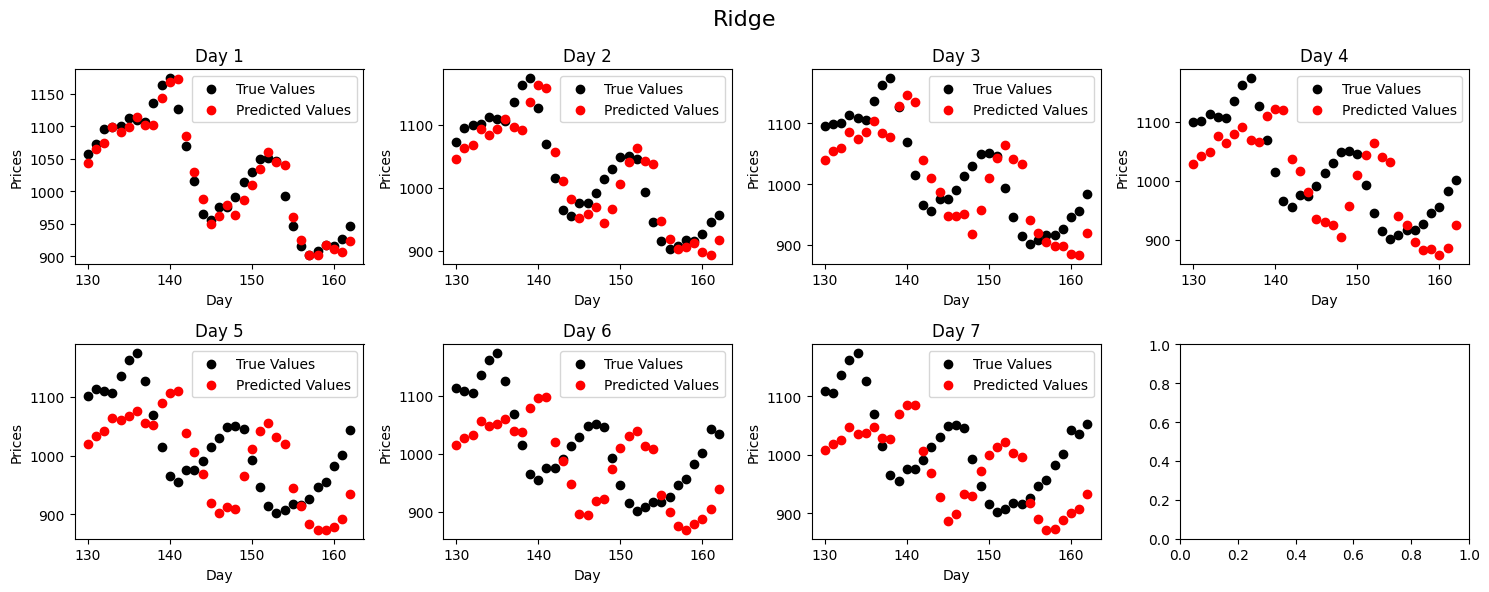

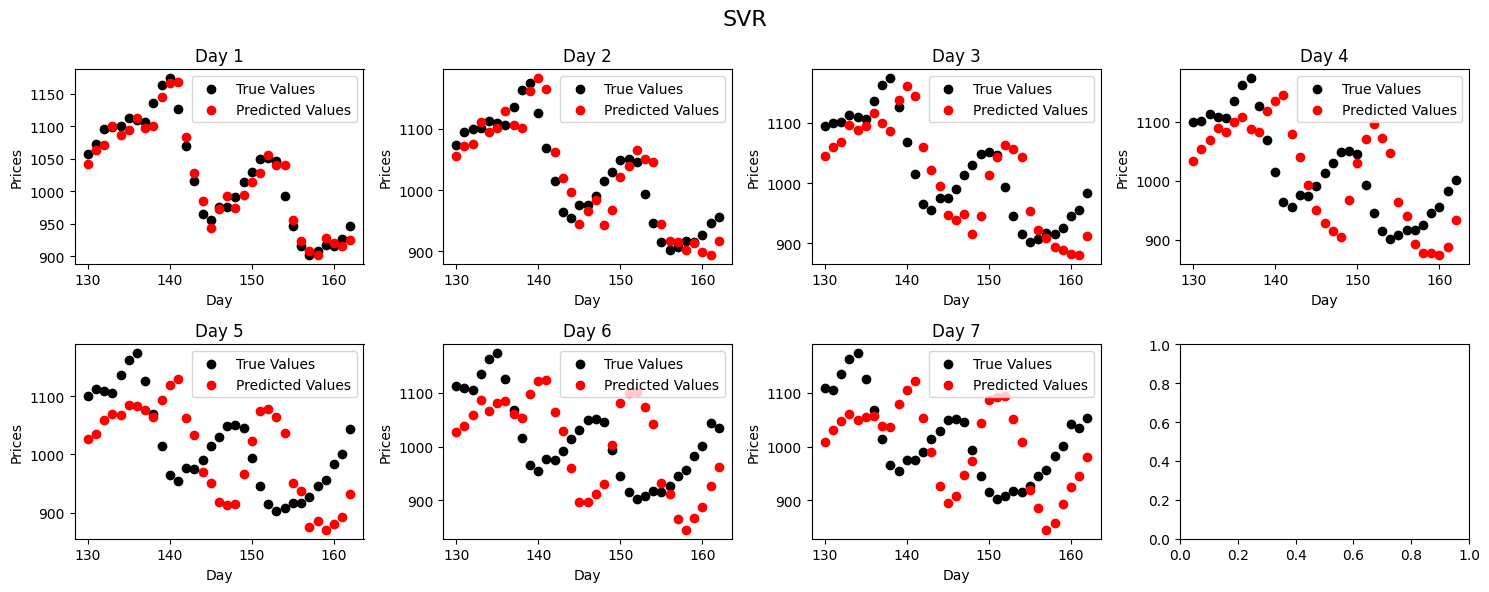

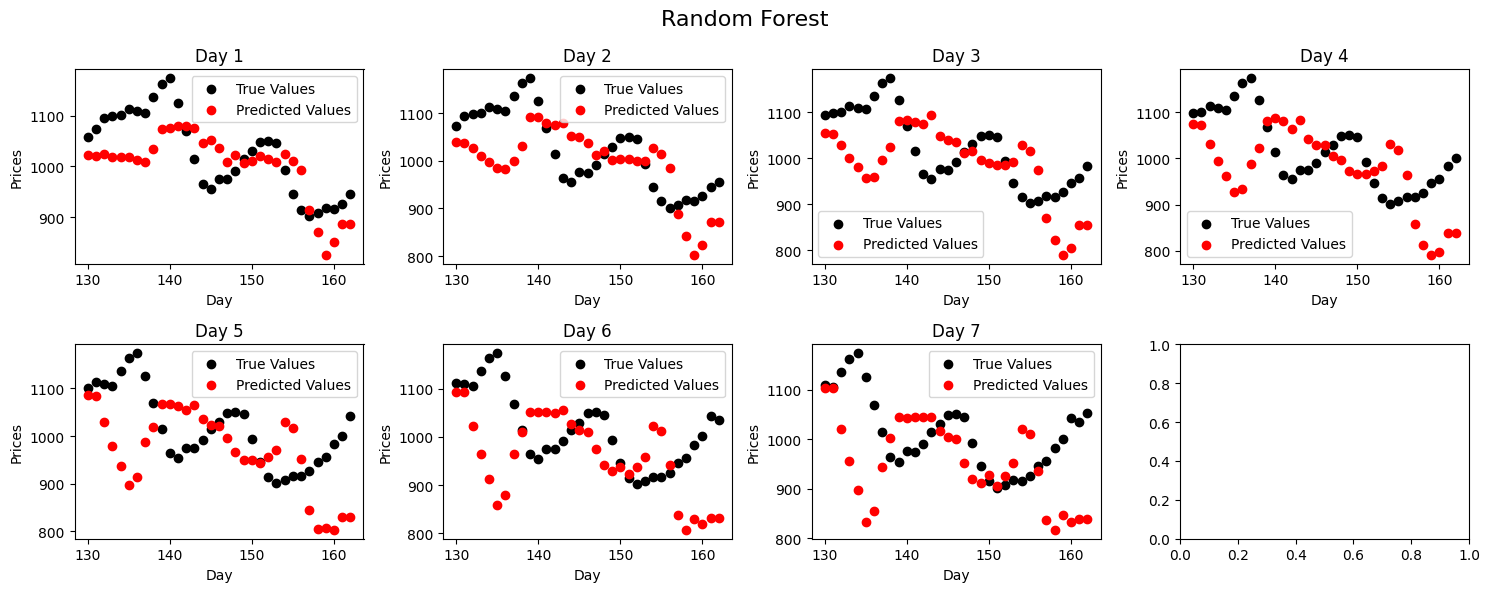

In [234]:

# Linear
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
for day in range(num_days_to_predict):
    row = day // 4
    col = day % 4
    axs[row, col].scatter(y_test_7.index, y_test_7[f"target_day_{day + 1}"], label="True Values", color="black")
    axs[row, col].scatter(y_test_7.index, lin_y_pred_7[:, day], label="Predicted Values", color="red")

    axs[row, col].set_xlabel("Day")
    axs[row, col].set_ylabel("Prices")
    axs[row, col].set_title(f"Day {day + 1}")

    axs[row, col].legend()

fig.suptitle("Linear", fontsize=16)
plt.tight_layout()
plt.show()

# Ridge
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
for day in range(num_days_to_predict):
    row = day // 4
    col = day % 4
    axs[row, col].scatter(y_test_7.index, y_test_7[f"target_day_{day + 1}"], label="True Values", color="black")
    axs[row, col].scatter(y_test_7.index, ridge_y_pred[:, day], label="Predicted Values", color="red")

    axs[row, col].set_xlabel("Day")
    axs[row, col].set_ylabel("Prices")
    axs[row, col].set_title(f"Day {day + 1}")

    axs[row, col].legend()

fig.suptitle("Ridge", fontsize=16)
plt.tight_layout()
plt.show()

# SVR
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
for day in range(num_days_to_predict):
    row = day // 4
    col = day % 4
    axs[row, col].scatter(y_test_7.index, y_test_7[f"target_day_{day + 1}"], label="True Values", color="black")
    axs[row, col].scatter(y_test_7.index, svr_y_pred[:, day], label="Predicted Values", color="red")

    axs[row, col].set_xlabel("Day")
    axs[row, col].set_ylabel("Prices")
    axs[row, col].set_title(f"Day {day + 1}")

    axs[row, col].legend()

fig.suptitle("SVR", fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
for day in range(num_days_to_predict):
    row = day // 4
    col = day % 4
    axs[row, col].scatter(y_test_7.index, y_test_7[f"target_day_{day + 1}"], label="True Values", color="black")
    axs[row, col].scatter(y_test_7.index, rf_y_pred_7[:, day], label="Predicted Values", color="red")

    axs[row, col].set_xlabel("Day")
    axs[row, col].set_ylabel("Prices")
    axs[row, col].set_title(f"Day {day + 1}")

    axs[row, col].legend()

fig.suptitle("Random Forest", fontsize=16)
plt.tight_layout()
plt.show()

# Conclusion  
Our linear model performs fairly well while predicting only one day into the future but struggles with predicting 7 days ahead. Models like linear regression, ridge regression, support vector with linear kernel, showed decent performance for 1 day predictions. However, their performance dropped significantly when for 7 day forecasts.  
  
Our linear models probably did better because the linear models were able capture the temporal dependecies in our observations. Meanwhile, the random forest model treats each observation indepedently, which might make it less able to capture the temporal and sequential relations in the data. In addition, our linear models are much simpler compared to the random forest, meaning that the random forest is much more likely to overfit. This is especially true in the short term 1 day prediction because the relations between the target and training data is much more direct.  

For 7 day predictions, all the models had an r2 adjusted close to zero or negative values, indicating that they fail to capture the variability in the data effectively. We can see where the model starts to fail when plotting the predictions with the true values in term of predicted day. The models are able to accurately predict the first two days, but by the third day, the prediction error starts to noticeably increase. The same pattern holds true for the random forest model, which performed even worse than the linear models.  
  
The 7 day prediction performance dropped probably due to the increased variability and uncertainty when trying to predict farther into the future. This seems to be true for all models, as we can see a decrease in performance across the board. The temporal dependecies that were captured may become less reliable the farther into the future we try to predict. If we look at the correlation matrix, we can see the drop in correlation as the days grow farther and farther apart. Also, previous errors may have accumulated and are thus magnified resulting in the massive drop in performance. Finally, the data we have may have been too limited to to train the model for long-term predictions.
  
Considering the low score when trying to predict 7 days, we should consider incorporating additional features such as moving statistics or other external economic indicators. In addition, we may need to explore more advance models that can handle the temporal dependecies betters, and we may need more features to train our models on.


# Citations
[1] Jagex (2007) *Grand Exchange* [Data set]. https://secure.runescape.com/m=itemdb_oldschool/api/graph/